### Import de librerias y configuracion de datos desde Supabase

In [181]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')
dbname = os.getenv('DB_NAME')

DATABASE_URL = f"postgresql://{user}:{password}@{host}:{port}/{dbname}"

engine = create_engine(DATABASE_URL)

---

### Creacion de los DFs

In [182]:
# Se definen todos los dataframes 
df_customers = pd.read_sql("SELECT * FROM customer",engine)
df_geolocation = pd.read_sql("SELECT * FROM geolocation",engine)
df_order_items = pd.read_sql("SELECT * FROM order_items",engine)
df_order_payments = pd.read_sql("SELECT * FROM order_payments",engine)
df_order_reviews = pd.read_sql("SELECT * FROM order_reviews",engine)
df_orders = pd.read_sql("SELECT * FROM orders",engine)
df_products = pd.read_sql("SELECT * FROM products",engine)
df_sellers = pd.read_sql("SELECT * FROM sellers",engine)
df_products_translated = pd.read_sql("SELECT * FROM products_translated", engine)


---

### Visualizacion preliminar de tablas 

In [183]:
# Detalles de los cliente
df_customers.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,08775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [184]:
# Se promedian las coordenadas ya que habia demasiadas latitudes y longitudes para un mismo zip code
df_geolocation["geolocation_lat"] = pd.to_numeric(df_geolocation["geolocation_lat"], errors="coerce")
df_geolocation["geolocation_lng"] = pd.to_numeric(df_geolocation["geolocation_lng"], errors="coerce")


# De manera manual se ejecuta un filtro sobre las latitudes y longitudes ya que habian valores atipicos que distorcionan las medias 
df_geolocation = df_geolocation[(df_geolocation["geolocation_lat"] <= 5.161220) & (df_geolocation["geolocation_lng"] <= -20)]


# Detalle de la ubicacion con varios zipcodes
promedio_coordenadas = df_geolocation.groupby("geolocation_zip_code_prefix").agg({
    "geolocation_lat": "mean",
    "geolocation_lng": "mean",
    "geolocation_city": lambda x: x.mode()[0],
    "geolocation_state": lambda x: x.mode()[0]
})
df_geolocation = pd.DataFrame(promedio_coordenadas).reset_index()
df_geolocation.rename(columns={"geolocation_zip_code_prefix" : "zip_code_prefix"})

,zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,01001,-23.550190,-46.634024,sao paulo,SP
1,01002,-23.548146,-46.634979,sao paulo,SP
2,01003,-23.548994,-46.635731,sao paulo,SP
3,01004,-23.549799,-46.634757,sao paulo,SP
4,01005,-23.549456,-46.636733,sao paulo,SP
...,...,...,...,...,...
19006,99960,-27.953722,-52.025511,charrua,RS
19007,99965,-28.183372,-52.039850,agua santa,RS
19008,99970,-28.343766,-51.874689,ciriaco,RS
19009,99980,-28.389129,-51.843836,david canabarro,RS


In [185]:
df_geolocation

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,01001,-23.550190,-46.634024,sao paulo,SP
1,01002,-23.548146,-46.634979,sao paulo,SP
2,01003,-23.548994,-46.635731,sao paulo,SP
3,01004,-23.549799,-46.634757,sao paulo,SP
4,01005,-23.549456,-46.636733,sao paulo,SP
...,...,...,...,...,...
19006,99960,-27.953722,-52.025511,charrua,RS
19007,99965,-28.183372,-52.039850,agua santa,RS
19008,99970,-28.343766,-51.874689,ciriaco,RS
19009,99980,-28.389129,-51.843836,david canabarro,RS


In [186]:
#Detalle a fondo de las compras (cuantos productos se vendieron), incluye precio y precio de envio
df_order_items.head(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35+00:00,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13+00:00,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30+00:00,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18+00:00,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51+00:00,199.90,18.14


In [187]:
# Detalla como se hizo el pago, cuotas y metodos
df_order_payments.head(5)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [188]:
# Detalla los comentarios y scores de las entregas, hay varios vacios
df_order_reviews.head(5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00+00:00,2018-01-18 21:46:59+00:00
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00+00:00,2018-03-11 03:05:13+00:00
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00+00:00,2018-02-18 14:36:24+00:00
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00+00:00,2017-04-21 22:02:06+00:00
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00+00:00,2018-03-02 10:26:53+00:00


In [189]:
# Informacion de fechas, estado de la entrega del pedido
df_orders.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33+00:00,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00+00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37+00:00,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00+00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49+00:00,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00+00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06+00:00,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00+00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39+00:00,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00+00:00


In [190]:
# Lista de los productos de la empresa, info como peso y medidas del producto
df_products.head(5)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [191]:
# Info de los puntos de ventas de la compañia
df_sellers.head(5)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,04195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


---

### Transformancion de datos

In [192]:
# funcion para verificar vacios
def verficar_vacios(dicc_tablas):
    print("==="*20)
    print("Info de celdas vacias")
    print("==="*20,"\n")
    for nom, df  in dicc_tablas.items():
        vacios = df.isna().sum()
        print(f"Dataframe: {nom}\n")
        print(vacios,"\n")
        print("==="*20)

dicc_tablas = {
    "df_customers": df_customers,
    "df_geolocation": df_geolocation,
    "df_order_items": df_order_items,
    "df_order_payments": df_order_payments,
    "df_order_reviews": df_order_reviews,
    "df_orders": df_orders,
    "df_products": df_products,
    "df_sellers": df_sellers
    }

verficar_vacios(dicc_tablas)

Info de celdas vacias

Dataframe: df_customers

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64 

Dataframe: df_geolocation

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64 

Dataframe: df_order_items

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64 

Dataframe: df_order_payments

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64 

Dataframe: df_order_reviews

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     

In [193]:
# funcion para convertir las columnas a formato fecha
def cambiar_a_formato_fecha(df, lista):
    for columna in lista:
        df[columna]=pd.to_datetime(df[columna], format="%d-%m-%Y", errors="coerce")
    return df

In [194]:
# se crean las listas con las columnas que se quiere verificar el cambio de variable a fecha
lista_orders = [
    "order_estimated_delivery_date",
    "order_delivered_customer_date",
    "order_delivered_carrier_date",
    "order_purchase_timestamp",
    "order_approved_at"
]
lista_order_items = [
    "shipping_limit_date"
]
lista_reviews = [
    "review_creation_date"
]
df_orders = cambiar_a_formato_fecha(df_orders, lista_orders)
df_order_items = cambiar_a_formato_fecha(df_order_items, lista_order_items)
df_order_reviews = cambiar_a_formato_fecha(df_order_reviews, lista_reviews)

In [195]:
# funcion para llenar todos los datos vacios por moda 
def llenar_moda(df):
    df_mod = df.fillna(df.mode().iloc[0])
    return df_mod

In [196]:
# Se llenan los valores vacios por la moda
df_products = llenar_moda(df_products)

In [197]:
# Se crea la columna payment value en la tabla orders 
valor_total = df_orders.merge(df_order_payments, how="inner")
valor_total = valor_total.groupby("order_id")["payment_value"].sum()
valor_total = pd.DataFrame(valor_total).reset_index()
df_orders = df_orders.merge(valor_total, how="inner")

*Se crea la columna "payment_value" en la tabla "orders" ya que no habia informacion del valor total de cada factura.*

---

### Tablas relevantes vistas a detalle

In [198]:
df_orders.describe(include="all", ).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
order_id,99440,99440,6ec4642f9993cc34f826cfb9068e5a2f,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_id,99440,99440,f00bb12620b7b232233cace1b229db18,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_status,99440,8,delivered,96477,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_purchase_timestamp,99440,NaN,NaN,NaN,2017-12-31 08:50:02.752393472+00:00,2016-09-04 21:15:19+00:00,2017-09-12 14:50:17.500000+00:00,2018-01-18 23:05:58+00:00,2018-05-04 15:42:52+00:00,2018-10-17 17:30:18+00:00,NaN
order_approved_at,99280,NaN,NaN,NaN,2017-12-31 18:42:15.093221120,2016-10-04 09:43:32,2017-09-12 23:25:00.249999872,2018-01-19 11:45:21.500000,2018-05-04 20:35:12.249999872,2018-09-03 17:40:06,NaN
order_delivered_carrier_date,97657,NaN,NaN,NaN,2018-01-04 21:56:02.549484288,2016-10-08 10:34:01,2017-09-15 22:31:51,2018-01-24 16:12:38,2018-05-08 13:38:00,2018-09-11 19:48:28,NaN
order_delivered_customer_date,96475,NaN,NaN,NaN,2018-01-14 12:15:45.188442624,2016-10-11 13:46:32,2017-09-25 22:08:08.500000,2018-02-02 19:28:30,2018-05-15 22:48:54.500000,2018-10-17 13:22:46,NaN
order_estimated_delivery_date,99440,NaN,NaN,NaN,2018-01-24 03:15:32.292839680+00:00,2016-09-30 00:00:00+00:00,2017-10-03 00:00:00+00:00,2018-02-15 00:00:00+00:00,2018-05-25 00:00:00+00:00,2018-11-12 00:00:00+00:00,NaN
payment_value,99440.0,NaN,NaN,NaN,160.990267,0.0,62.01,105.29,176.97,13664.08,221.951257


In [199]:
df_order_items.describe(include="all").T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
order_id,112650,98666,8272b63d03f5f79c56e9e4120aec44ef,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_item_id,112650.0,NaN,NaN,NaN,1.197834,1.0,1.0,1.0,1.0,21.0,0.705124
product_id,112650,32951,aca2eb7d00ea1a7b8ebd4e68314663af,527,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seller_id,112650,3095,6560211a19b47992c3666cc44a7e94c0,2033,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shipping_limit_date,112650,NaN,NaN,NaN,2018-01-07 15:36:52.192685312+00:00,2016-09-19 00:15:34+00:00,2017-09-20 20:57:27.500000+00:00,2018-01-26 13:59:35+00:00,2018-05-10 14:34:00.750000128+00:00,2020-04-09 22:35:08+00:00,NaN
price,112650.0,NaN,NaN,NaN,120.653739,0.85,39.9,74.99,134.9,6735.0,183.633928
freight_value,112650.0,NaN,NaN,NaN,19.99032,0.0,13.08,16.26,21.15,409.68,15.806405


In [200]:
df_order_payments.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
order_id,103886,99440,fa65dad1b0e818e3ccc5cb0e39231352,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_sequential,103886.0,NaN,NaN,NaN,1.092679,0.706584,1.0,1.0,1.0,1.0,29.0
payment_type,103886,5,credit_card,76795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_installments,103886.0,NaN,NaN,NaN,2.853349,2.687051,0.0,1.0,1.0,4.0,24.0
payment_value,103886.0,NaN,NaN,NaN,154.10038,217.494064,0.0,56.79,100.0,171.8375,13664.08


* *Metodo de pago mas usado "credit_card" con un promedio de installments de "1.09"*
* *La gran mayoria de personas solo utiliza un metodo de pago*
* *El promedio de productos por ticket es de "1.19", al menos el 75% de las ordenes tienen solo 1 producto*
* *En las variables de precios (price, freight, payment value) se evidencia de preliminarmente una alta dispercion con los valores superiores al Q3, lo que sugiere outliers significativos*

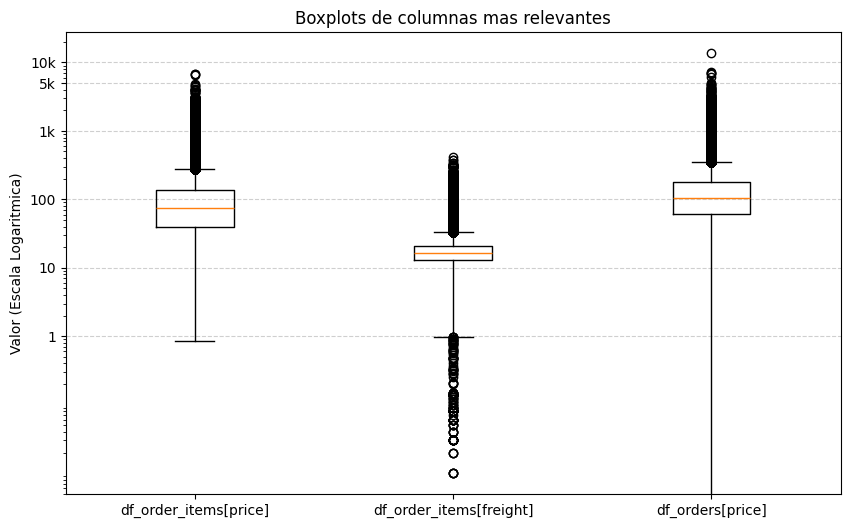

In [201]:
# Se hacen boxplots de las variables de precio para entender los outliers
datos_para_graficar = [
    df_order_items["price"].dropna(), 
    df_order_items["freight_value"].dropna(), 
    df_orders["payment_value"].dropna()
]

plt.figure(figsize=(10, 6))
plt.boxplot(datos_para_graficar, tick_labels=["df_order_items[price]", "df_order_items[freight]", "df_orders[price]"])
plt.yscale("log")
plt.yticks(
    [1, 10, 100, 1000, 5000, 10000],
    ["1", "10", "100", "1k", "5k", "10k"]
)
plt.title("Boxplots de columnas mas relevantes")
plt.ylabel("Valor (Escala Logaritmica)")
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

In [202]:
# Se revisa el rango intercuartilico para comparar con valores minimos y verificar que en verdad no haya outliers inferiores
Q1 = df_orders["payment_value"].quantile(0.25)
Q3 = df_orders["payment_value"].quantile(0.75)
IQR = Q3 - Q1
print(f"El Rango Intercuartílico es: {IQR}")
print(f"Los valores en df_orders'payment_value' menores a {Q1-(1.5*IQR)}, se consideran outliers inferiores\n")
# ------------------------------------------
Q1 = df_order_items["price"].quantile(0.25)
Q3 = df_order_items["price"].quantile(0.75)
IQR = Q3 - Q1
print(f"El Rango Intercuartílico es: {IQR}")
print(f"Los valores en df_order_items'price' menores a {Q1-(1.5*IQR)}, se consideran outliers inferiores")

El Rango Intercuartílico es: 114.96000000000001
Los valores en df_orders'payment_value' menores a -110.43, se consideran outliers inferiores

El Rango Intercuartílico es: 95.0
Los valores en df_order_items'price' menores a -102.6, se consideran outliers inferiores


*Se compara los valores minimos con los valores intercuartilicos, y se determina que en efecto no hay outliers ya que no hay valores menores a 0*

---

### Discrepancia en los datos en la tabla orders con order_items

In [203]:
print(f"En la tabla 'orders' hay un total de {df_orders['order_id'].nunique()} filas, y en 'order_items' {df_order_items['order_id'].nunique()} filas")
print(f"Hay un vacio de: ",df_orders['order_id'].nunique() - df_order_items['order_id'].nunique(),"filas")

En la tabla 'orders' hay un total de 99440 filas, y en 'order_items' 98666 filas
Hay un vacio de:  774 filas


*Se detectó una diferencia de 774 órdenes sin detalle de productos en order_items. Aunque estas órdenes cuentan con información en orders y payments, no es posible analizar su composición de productos. Se opta por conservarlas y documentar la limitación para análisis posteriores.*

---

### Modelo relacional

<img src="../Images/modelo_relacional.png" width="70%">

### Se verifica que los IDs de tablas dim esten en tablas fact 

In [204]:
ids_order_items = set(df_order_items["order_id"])
ids_orders = set(df_orders["order_id"])

num_faltantes = ids_order_items-ids_orders
print(f"Hay {len(num_faltantes)} IDs que no estan en df_orders")
num_faltantes

Hay 1 IDs que no estan en df_orders


{'bfbd0f9bdef84302105ad712db648a6c'}

*Se revisa que todos los IDs en la tabla df_order_items esten vinculados en df_orders, ya que la tabla de "items" es el desglose de la tabla principal. Sin embargo, se evidencia que solo 1 ID no hace match con la tabla principal, se procede a borrar dicha fila*

In [205]:
# Se borra la fila del unico ID que no hace match, esta informacion es irrelevante por su cantidad y porque es una tabla secundaria
df_order_items = df_order_items[df_order_items["order_id"] != "bfbd0f9bdef84302105ad712db648a6c"]

---

### Se crea la columna de cantidad de productos para analisis de correlacion respecto al valor de factura

In [206]:
cantidad = df_order_items.groupby("order_id")["order_item_id"].count().sort_values(ascending=False)
cantidad = pd.DataFrame(cantidad).reset_index()
cantidad = cantidad.rename(columns={"order_item_id":"products_quantity"})
df_orders = df_orders.merge(cantidad, how="left")


In [207]:
print(f"Pearson: {round(df_orders['products_quantity'].corr(df_orders['payment_value'], method='pearson'),3)}")
print(f"Spearman: {round(df_orders['products_quantity'].corr(df_orders['payment_value'], method='spearman'),3)}")

Pearson: 0.189
Spearman: 0.221


* *Se utilizan 2 metodos para ver la correlacion entre ambas variables, Pearson como metodo general y Spearman ya que es menos sensible a outliers extremos como en la columna de payment_value*

* *Se puede ver una baja relacion entre la columna de cantidad respecto a valor total (0.189), esto sugiere 2 escenarios. Primero, puede que la cantidad de productos que se compre sea alta pero su valor unitario es bajo, esto tiene sentido viendo los boxplots de los valores de los productos. Segundo, puede que la cantidad sea baja pero valores con valores unitarios altos, tal y como sugiere de nuevo los graficos de boxplot*

---

### Distribucion de la cantidad de las ordenes vs su valor

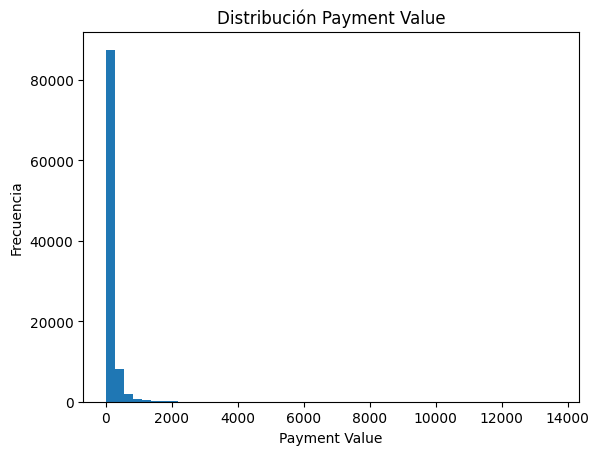

In [208]:
plt.hist(df_orders["payment_value"], bins=50)
plt.title("Distribución Payment Value")
plt.xlabel("Payment Value")
plt.ylabel("Frecuencia")
plt.show()


*Se visualiza una asimetria positiva, con una alta concentracion de ordenes de "bajo" valor.*

---

### Distribucion del 80% del acumulado de las ganancias

In [209]:
df_pareto = df_orders.sort_values(by='payment_value', ascending=False).copy()
total_revenue = df_pareto["payment_value"].sum()
df_pareto["acumulado"] = df_pareto["payment_value"].cumsum()
df_pareto["porcentaje_acum"] = df_pareto["acumulado"] / total_revenue
top_80_ingresos = df_pareto[df_pareto['porcentaje_acum'] <= 0.80]
cantidad_ordenes_top = len(top_80_ingresos)
total_ordenes = len(df_pareto)
porcentaje_ordenes = (cantidad_ordenes_top / total_ordenes) * 100

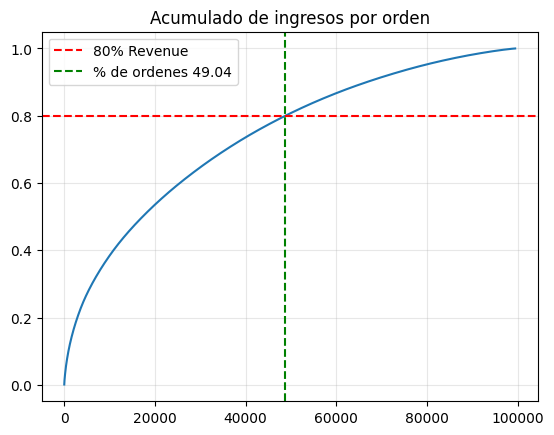

In [210]:
x = range(len(df_pareto))
y = df_pareto["porcentaje_acum"]

plt.plot(x,y)
plt.axhline(y=0.8, color='red', linestyle='--', label='80% Revenue')
plt.axvline(x=cantidad_ordenes_top, color='green', linestyle='--', label=f'% de ordenes {round(porcentaje_ordenes,2)}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title(f"Acumulado de ingresos por orden")
plt.show()

*Aunque una parte significativa del revenue (80%) proviene de un porcentaje moderado de órdenes (49.04), no existe una concentración extrema. Esto significa que la estrategia del negocio se basa tanto en un volumen constante de transacciones como en la contribución de órdenes de mayor valor*

---

### Terciles en payment_value y su distribucion con el numero de ordenes

In [211]:
limite_bajo = df_orders["payment_value"].quantile(0.33)
limite_medio = df_orders["payment_value"].quantile(0.66)
limite_alto = df_orders["payment_value"].quantile(1)

df_valor_bajo = df_orders[df_orders["payment_value"]<=limite_bajo]
df_valor_medio= df_orders[(df_orders["payment_value"]>limite_bajo) & (df_orders["payment_value"]<=limite_medio)]
df_valor_alto = df_orders[df_orders["payment_value"]>limite_medio]

dicc_percen = {
    "Bajo": [df_valor_bajo.shape[0],df_valor_bajo["payment_value"].sum(),round(((df_valor_bajo["payment_value"].sum()/df_orders["payment_value"].sum()*100)),2)],
    "Medio": [df_valor_medio.shape[0],df_valor_medio["payment_value"].sum(),round(((df_valor_medio["payment_value"].sum()/df_orders["payment_value"].sum()*100)),2)],
    "Alto": [df_valor_alto.shape[0],df_valor_alto["payment_value"].sum(),round(((df_valor_alto["payment_value"].sum()/df_orders["payment_value"].sum()*100)),2)]
}

dicc_percen = pd.DataFrame.from_dict(dicc_percen, orient='index', columns=['# de ordenes',"revenue","% del revenue total"])
dicc_percen


,# de ordenes,revenue,% del revenue total
Bajo,32824,1605091.28,10.03
Medio,32809,3472067.07,21.69
Alto,33807,10931713.77,68.29


In [212]:
### Se añade una columna con su clasificacion de segmento
df_orders["segment"] = pd.qcut(df_orders['payment_value'], q=[0, 0.33, 0.66, 1], labels=['Bajo', 'Medio', 'Alto'])

*A comparacion del grafico de pareto donde no reflejaba gran concentracion, por medio de los terciles se concluye que, los tickets de valor "alto" reflejan un porcentaje del 68.29 en el revenue total.*

---

### Analisis detallado del grupo de ordenes de valor "alto"

In [213]:
# merges de todas las tablas necesarias para analisis detallado
df_valor_alto_merged = df_valor_alto.merge(df_order_items, on="order_id", how="left")
df_valor_alto_merged = df_valor_alto_merged.merge(df_order_payments,on="order_id", how="left")
df_valor_alto_merged = df_valor_alto_merged.merge(df_products,on="product_id", how="left")
df_valor_alto_merged = df_valor_alto_merged.merge(df_products_translated,on="product_category_name", how="left")

In [214]:
df_valor_alto_merged.groupby("product_category_name_english")["order_id"].nunique().sort_values(ascending=False).head(5)

product_category_name_english
bed_bath_table           3272
watches_gifts            3041
health_beauty            2857
sports_leisure           2557
computers_accessories    2475
Name: order_id, dtype: int64

In [215]:
df_valor_alto_merged.groupby("payment_installments")["order_id"].nunique().sort_values(ascending=False).head(5)

payment_installments
1     11002
10     4212
3      4090
2      3624
8      3067
Name: order_id, dtype: int64

In [216]:
df_valor_alto_merged.groupby("payment_type")["order_id"].nunique().sort_values(ascending=False)

payment_type
credit_card    27304
boleto          5782
voucher         1012
debit_card       428
Name: order_id, dtype: int64

### Contraste segmento "alto" y "bajo"

In [217]:
# merges de todas las tablas necesarias para analisis detallado
df_valor_bajo_merged = df_valor_bajo.merge(df_order_items, on="order_id", how="left")
df_valor_bajo_merged = df_valor_bajo_merged.merge(df_order_payments,on="order_id", how="left")
df_valor_bajo_merged = df_valor_bajo_merged.merge(df_products,on="product_id", how="left")
df_valor_bajo_merged = df_valor_bajo_merged.merge(df_products_translated,on="product_category_name", how="left")

In [218]:
df_valor_bajo_merged.groupby("product_category_name_english")["order_id"].nunique().sort_values(ascending=False).head(5)

product_category_name_english
telephony         3128
bed_bath_table    3031
health_beauty     2742
housewares        2326
sports_leisure    2214
Name: order_id, dtype: int64

In [219]:
df_valor_bajo_merged.groupby("payment_installments")["order_id"].nunique().sort_values(ascending=False).head(5)

payment_installments
1    22069
2     3786
3     3054
4     1768
5     1253
Name: order_id, dtype: int64

In [220]:
df_valor_bajo_merged.groupby("payment_type")["order_id"].nunique().sort_values(ascending=False)

payment_type
credit_card    23805
boleto          7550
voucher         1597
debit_card       629
not_defined        3
Name: order_id, dtype: int64

*Se observa una clara relación entre el número de cuotas y el valor del ticket. Las órdenes de alto valor presentan una mayor frecuencia de pagos en múltiples cuotas (incluso superiores a 10), mientras que los tickets bajos se concentran en pagos de 1 a 5 cuotas. Esto sugiere que el financiamiento actúa como facilitador para compras de mayor monto*

---

### Conclusiones generales de analisis

* *La variable payment_value presenta una media de 160 y una desviación estándar de 221, resultando en un coeficiente de variación aproximado de 1.38. Este valor indica una alta dispersión relativa, consistente con una distribución asimétrica y presencia de órdenes de alto valor.*

* *El análisis de Pareto muestra que el 80% del revenue se alcanza aproximadamente con el 49% de las órdenes, lo que evidencia una concentración moderada del ingreso, aunque no extrema.*

* *La correlación de Spearman entre cantidad y payment_value fue de 0.22, lo que sugiere una relación positiva débil. Esto indica que el incremento en número de productos no necesariamente implica un aumento proporcional en el valor total de la orden.*

* *La distribución de payment_value presenta una fuerte asimetría positiva, evidenciada tanto en el histograma como en el elevado coeficiente de variación.*

---

### Exportar los DFs con las modificaciones hechas en pasos anteriores


In [221]:
ruta = "../Data/Transformed data/"
df_orders.to_csv(ruta + "orders.csv", index=False)
df_order_items.to_csv(ruta + "order_items.csv", index=False)
df_order_payments.to_csv(ruta + "order_payments.csv", index=False)
df_order_reviews.to_csv(ruta + "order_reviews.csv", index=False)
df_customers.to_csv(ruta + "customers.csv", index=False)
df_sellers.to_csv(ruta + "sellers.csv", index=False)
df_products.to_csv(ruta + "products.csv", index=False)
df_geolocation.to_csv(ruta + "geolocation.csv", index=False)